# Network Analysis:
## Advancing the utility of SPC
The following code generates the figures found in the essay *Network Analysis: Advancing the utility of SPC*. The essay can be found [here](https://static1.squarespace.com/static/5b722db6f2e6b1ad5053391b/t/679910513be40134de9b54f7/1738084433790/Network+analysis.pdf).

Figures 3 through 7 are generated using the Python package `process_improvement.py`. This package can be found [here](https://pypi.org/project/process-improvement/). Package can be installed using `pip install process-improvement`.

In [34]:
# Import libraries
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
# Figure 3 is generated using xmr.xmrchart()
from process_improvement import xmr_charts as xmr
# Figures 4 and 5 are generated using pc.capability_histogram()
from process_improvement import process_capability as pc
# Figures 6 and 7 are generated using network analysis module
from process_improvement import network_analysis as na

%matplotlib inline

In [35]:
# Specify path to data
dataset_url = "https://raw.githubusercontent.com/jimlehner/broken-quality-initiative/refs/heads/main/data/network_analysis_advancing_spc-manufacturing_process_data.csv"

# Read csv from URL
def get_data() -> pd.DataFrame:
    return pd.read_csv(dataset_url)

# Get data
all_data_df = get_data()

# Specify 'Observation' column as dtype string
all_data_df['Observation'] = all_data_df['Observation'].astype('string')
# Display dataframe
all_data_df.head()
all_data_df.columns

Index(['Observation', 'Machine 1', 'Machine 2', 'Machine 3', 'Machine 4',
       'Machine 5', 'Machine 6', 'Machine 7', 'Machine 8',
       'Machine 5 - Initial'],
      dtype='object')

## Fig 3: XmR Chart of Machine 5

In [48]:
# Create df for Machine 5 - Initial settings
M5_initial_df = all_data_df[['Observation','Machine 5 - Initial']]
M5_initial_df.head()

,Observation,Machine 5 - Initial
0,1,7.14
1,2,6.90
2,3,7.52
3,4,7.25
4,5,7.65


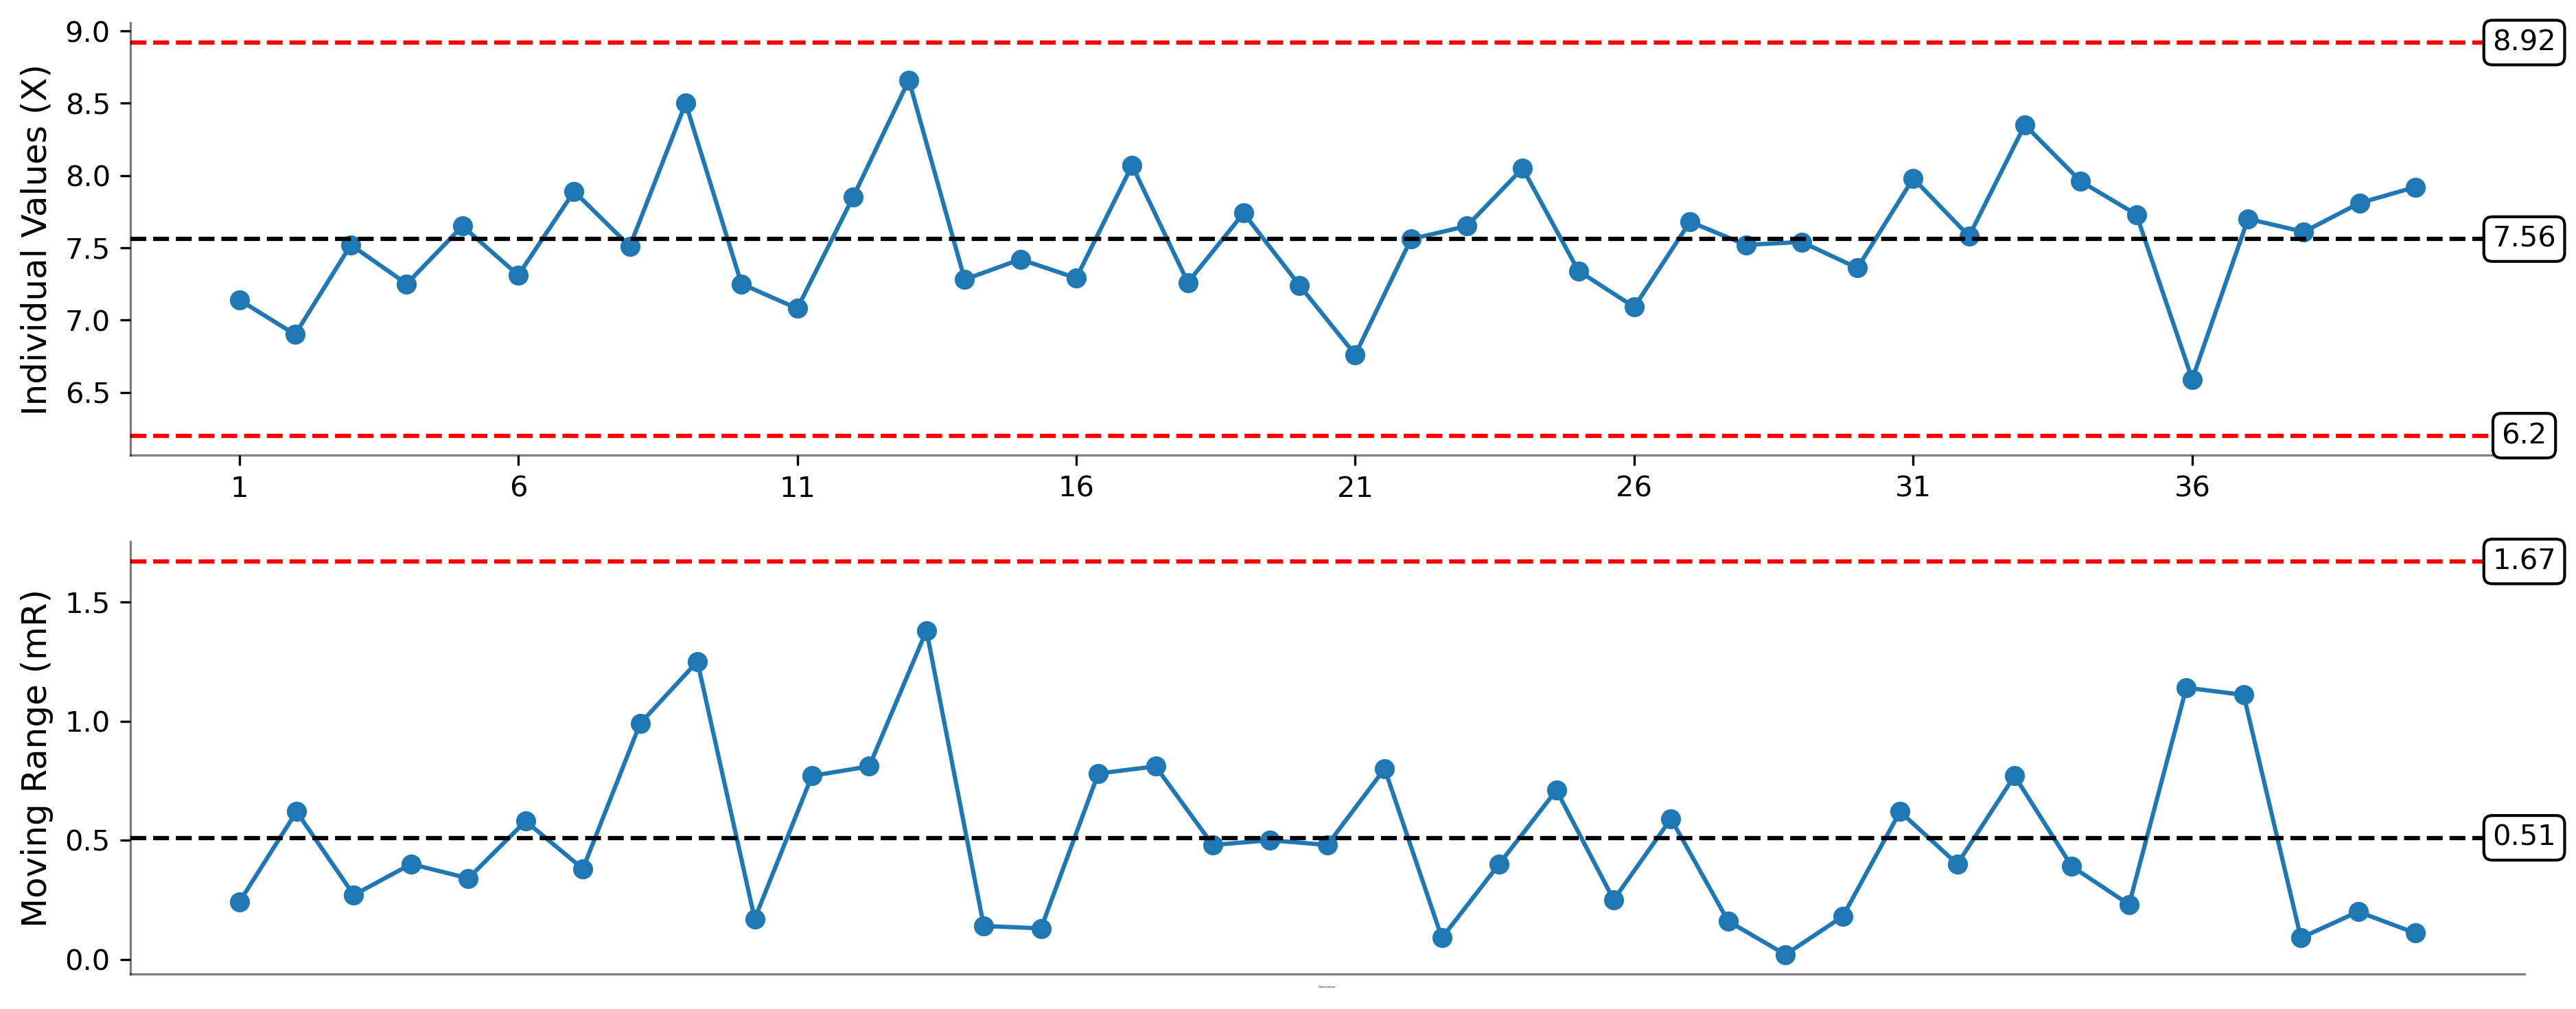

In [49]:
# Create XmR Chart of Machine 5 before adjustment
M5_initial_results = xmr.xmrchart(M5_initial_df, 'Machine 5 - Initial', 'Observation')

In [50]:
# Show M5 initial results
M5_initial_results['XmR Chart Statistics']

,Chart,PBC Params,Param Values
0,X-Chart,Mean,7.56
1,X-Chart,UPL,8.92
2,X-Chart,LPL,6.20
3,X-Chart,PLR,2.72
4,mR-Chart,Ave. mR,0.51
5,mR-Chart,URL,1.67


## Fig 4: Capability histogram of M5 initial settings

In [51]:
# Specify tolerance, target, USL, and LSL
tolerance = 4.8
target = 6
USL = target + (tolerance/2)
LSL = target - (tolerance/2)

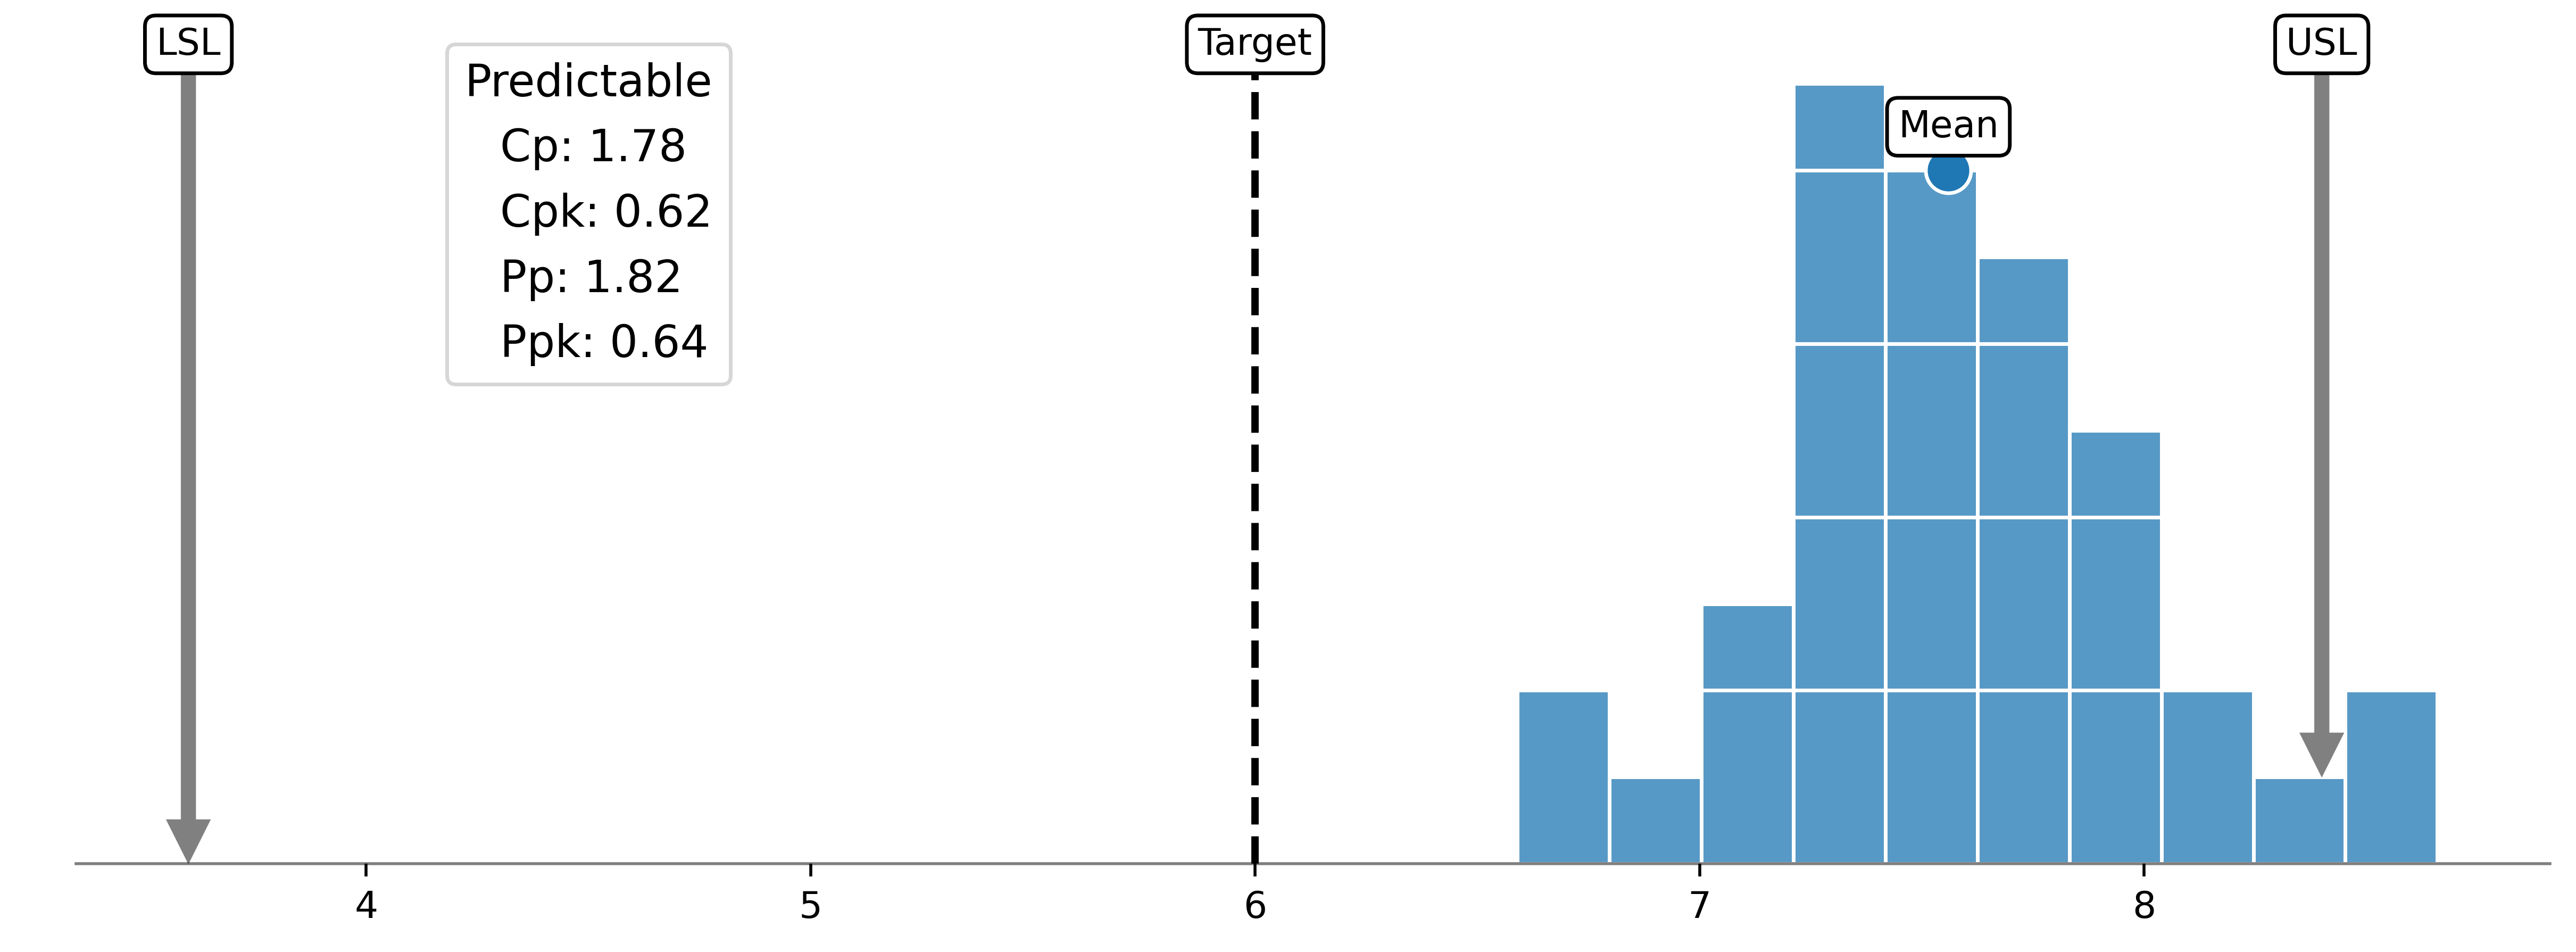

{'Characterization': 'Predictable',
 'Cp': 1.78,
 'Cpk': 0.62,
 'Pp': 1.82,
 'Ppk': 0.64}

In [52]:
pc.capability_histogram(M5_df['Machine 5 - Initial'], USL, LSL, target)

## Fig 5: Multi-chart of Machine 5 after adjustments

In [54]:
# Create DataFrame for Machine 5 after adjustment
M5_adjusted_df = all_data_df[['Observation','Machine 5']]
M5_adjusted_df.head()

,Observation,Machine 5
0,1,5.96
1,2,5.69
2,3,6.03
3,4,6.40
4,5,5.65


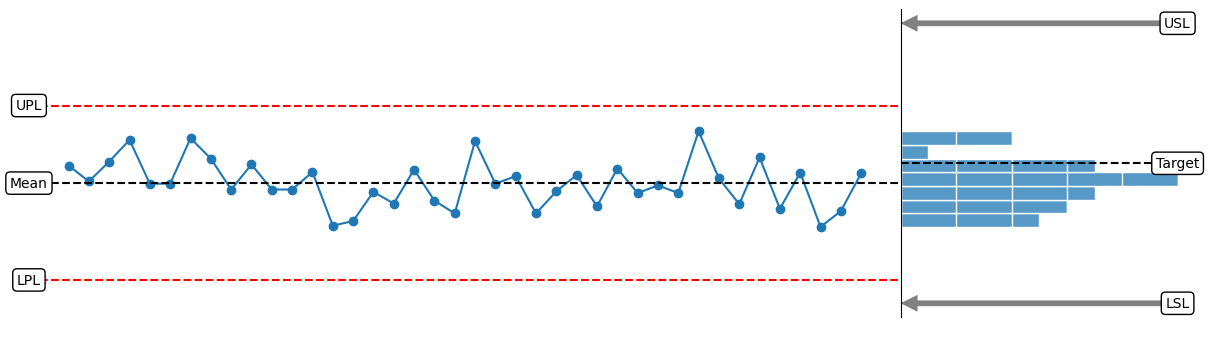

In [144]:
# pc.multi_chart without capability indices displayed
pc.multi_chart(M5_adjusted_df, 'Machine 5', 'Observation',
              USL, LSL, target, subplot_titles=['',''], 
              show_xticks=False)

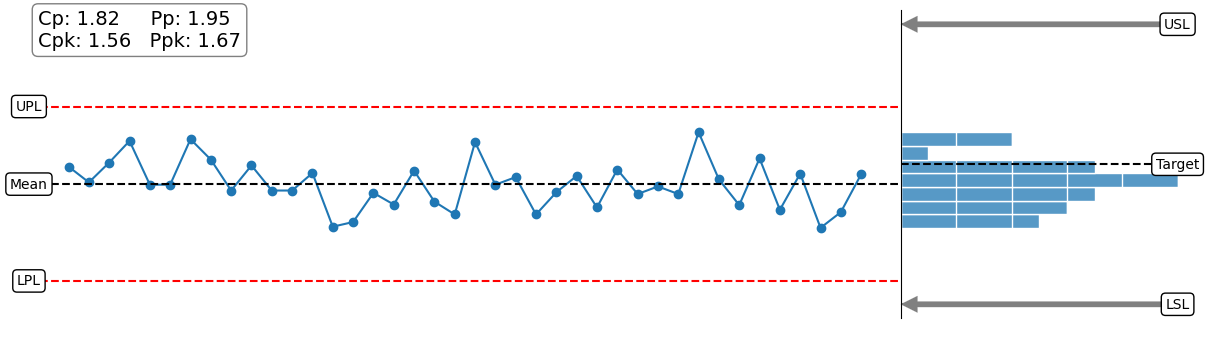

In [152]:
# Create data and labels objects
data = M5_adjusted_df['Machine 5']
labels = M5_adjusted_df['Observation']

# Show limit values and xticks
show_limit_values=False
show_xticks=False

# Calculate  moving range
moving_range = round(abs(data.diff()),round_value)

# Calculate the mean
mean = round(data.mean(),round_value)
# Calculate the average moving range 
average_mR = round(moving_range.mean(),round_value)

# Define the value of C1 and C2and calculate the UPL and LPL
C1 = 2.660
C2 = 3.268
# Calculate the process limits
UPL = round(mean + (C1*average_mR),round_value)
LPL = round(max(mean - (C1*average_mR),round_value),0)

# Create masking parameters for values greater than and less than the process limits on X-chart
upper_lim = np.ma.masked_where(data < UPL, data)
lower_lim = np.ma.masked_where(data > LPL, data)

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
xchart_lines = [(mean,'black'), (UPL,'red'), (LPL,'red')]

# Create list of tuples that specify value and color for mean, AmR, UPL, LPL, and URL
limit_chart_lines = [(target,'black'), (USL,'grey'), (LSL,'grey')]

# Generate fig, ax
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(15,4), 
                     gridspec_kw={'width_ratios': [3, 1]}, sharey=True)
plt.subplots_adjust(wspace=0)

# Plot process behavior chart to ax[0]
ax[0].plot(labels, data, marker='o')

# Add masking parameters to color values outside process limits
ax[0].plot(labels, lower_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)
ax[0].plot(labels, upper_lim, marker='o', ls='none', color='tab:red',
        markeredgecolor='black', markersize=9)

# Add centerline and process limits 
for value, color in xchart_lines:
    ax[0].axhline(value, ls='--', c=color)

# Histogram  of values to ax[1]
histplot=sns.histplot(y=data, ax=ax[1], edgecolor='white')

# Add centerline and process limits 
for value, color in limit_chart_lines:
    ax[1].axhline(value, ls='--', c=color)

# Use numpy histogram to calculate bin counts
counts, bins = np.histogram(data, bins='auto')

# Get the maximum height of the bars
max_count = max(counts)

# Assuming ax[0] is the axis where the label is to be placed
if show_limit_values:
    limit_labels = [UPL, LPL, mean, USL, LSL, target]
else:
    limit_labels = ['UPL', 'LPL', 'Mean', 'USL', 'LSL','Target']

# Get current x-limits
xlim = ax[0].get_xlim()
left_limit = xlim[0]

# Define the annotation data
annotations = [
    (limit_labels[0], left_limit, UPL, ax[0]),  # UPL annotation on ax[0]
    (limit_labels[1], left_limit, LPL, ax[0]),  # LPL annotation on ax[0]
    (limit_labels[2], left_limit, mean, ax[0]),  # Mean annotation on ax[0]
    (limit_labels[3], max_count, USL, ax[1]),  # USL annotation on ax[1]
    (limit_labels[4], max_count, LSL, ax[1]),  # LSL annotation on ax[1]
    (limit_labels[5], max_count, target, ax[1])  # Target annotation on ax[1]
]

# Add annotations
for label, x_pos, y_pos, axis in annotations:
    axis.annotate(label,
                  xy=(x_pos, y_pos),
                  ha='center',
                  va='center',
                  bbox=dict(facecolor='white', boxstyle='round'))

# Define arrow annotations (no text, only arrows)
arrows = [(LSL, 'grey'), (USL, 'grey')]  # LSL and USL arrows with their colors

# Loop through each arrow and annotate
for y_pos, color in arrows:
    ax[1].annotate(
        '',  # No text for the annotation
        xy=(0, y_pos),  # Bottom point (base of the arrow)
        xytext=(ax[1].get_xlim()[1], y_pos),  # Point to start the arrow from (behind the USL)
        arrowprops=dict(color=color, lw=0.1),
        zorder=2
    )

# Set the x-tick labels with increased intervals
if show_xticks:
    tick_interval = tick_interval  # Increase this value to increase the spacing between ticks
    tick_positions = np.arange(0, len(labels), tick_interval)
    ax[0].set_xticks(tick_positions)
    ax[0].set_xticklabels(labels.iloc[tick_positions], rotation=0, ha='center')
else:
    ax[0].set_xticks([])

# Remove the yticks from the X Chart
ax[0].set_yticks([])

# Specify spine visibility 
sns.despine()

# Set visiblity of specific spines on X Chart and histogram
ax[0].spines[['left','bottom']].set_visible(False)
ax[1].spines['bottom'].set_visible(False)

# Remove xlabel from histogram
ax[1].set_xlabel('')

# Set the color of the y-tick labels on the histogram to white
for label in ax[1].get_xticklabels():
    label.set_color('white')

ax[1].tick_params(axis='x', color='white')

# Ensure that the y-grid is still visible
ax[1].xaxis.grid(True, color='white', linestyle='-', linewidth=1, zorder=1)  # Re-enable the y-grid

# Capability indices 
ax[0].annotate('Cp: 1.82     Pp: 1.95\nCpk: 1.56   Ppk: 1.67',
              xy=(-1.5,8.3),
               ha='left',
               va='center',
              fontsize=14, bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round'))

# Show plot
plt.show()

## Fig 6: Network analysis

In [62]:
network_analysis_df = all_data_df.drop(columns=['Machine 5 - Initial'])
network_analysis_df.columns

Index(['Observation', 'Machine 1', 'Machine 2', 'Machine 3', 'Machine 4',
       'Machine 5', 'Machine 6', 'Machine 7', 'Machine 8'],
      dtype='object')

In [81]:
# Trasnform dataframe into list of dataframes
list_of_dfs = [network_analysis_df[[col]].rename(columns={col: 'Values'}) for col in network_analysis_df.columns[1:]]
# List of dfs should be length 8
len(list_of_dfs)

8

In [70]:
# Create list of labels to use in the network analysis
list_of_labels = network_analysis_df.columns.tolist()
# Reduce list to just machine names
list_of_labels = list_of_labels[1:9]
# List of labels should be a list of all 8 machine labels
list_of_labels

['Machine 1',
 'Machine 2',
 'Machine 3',
 'Machine 4',
 'Machine 5',
 'Machine 6',
 'Machine 7',
 'Machine 8']

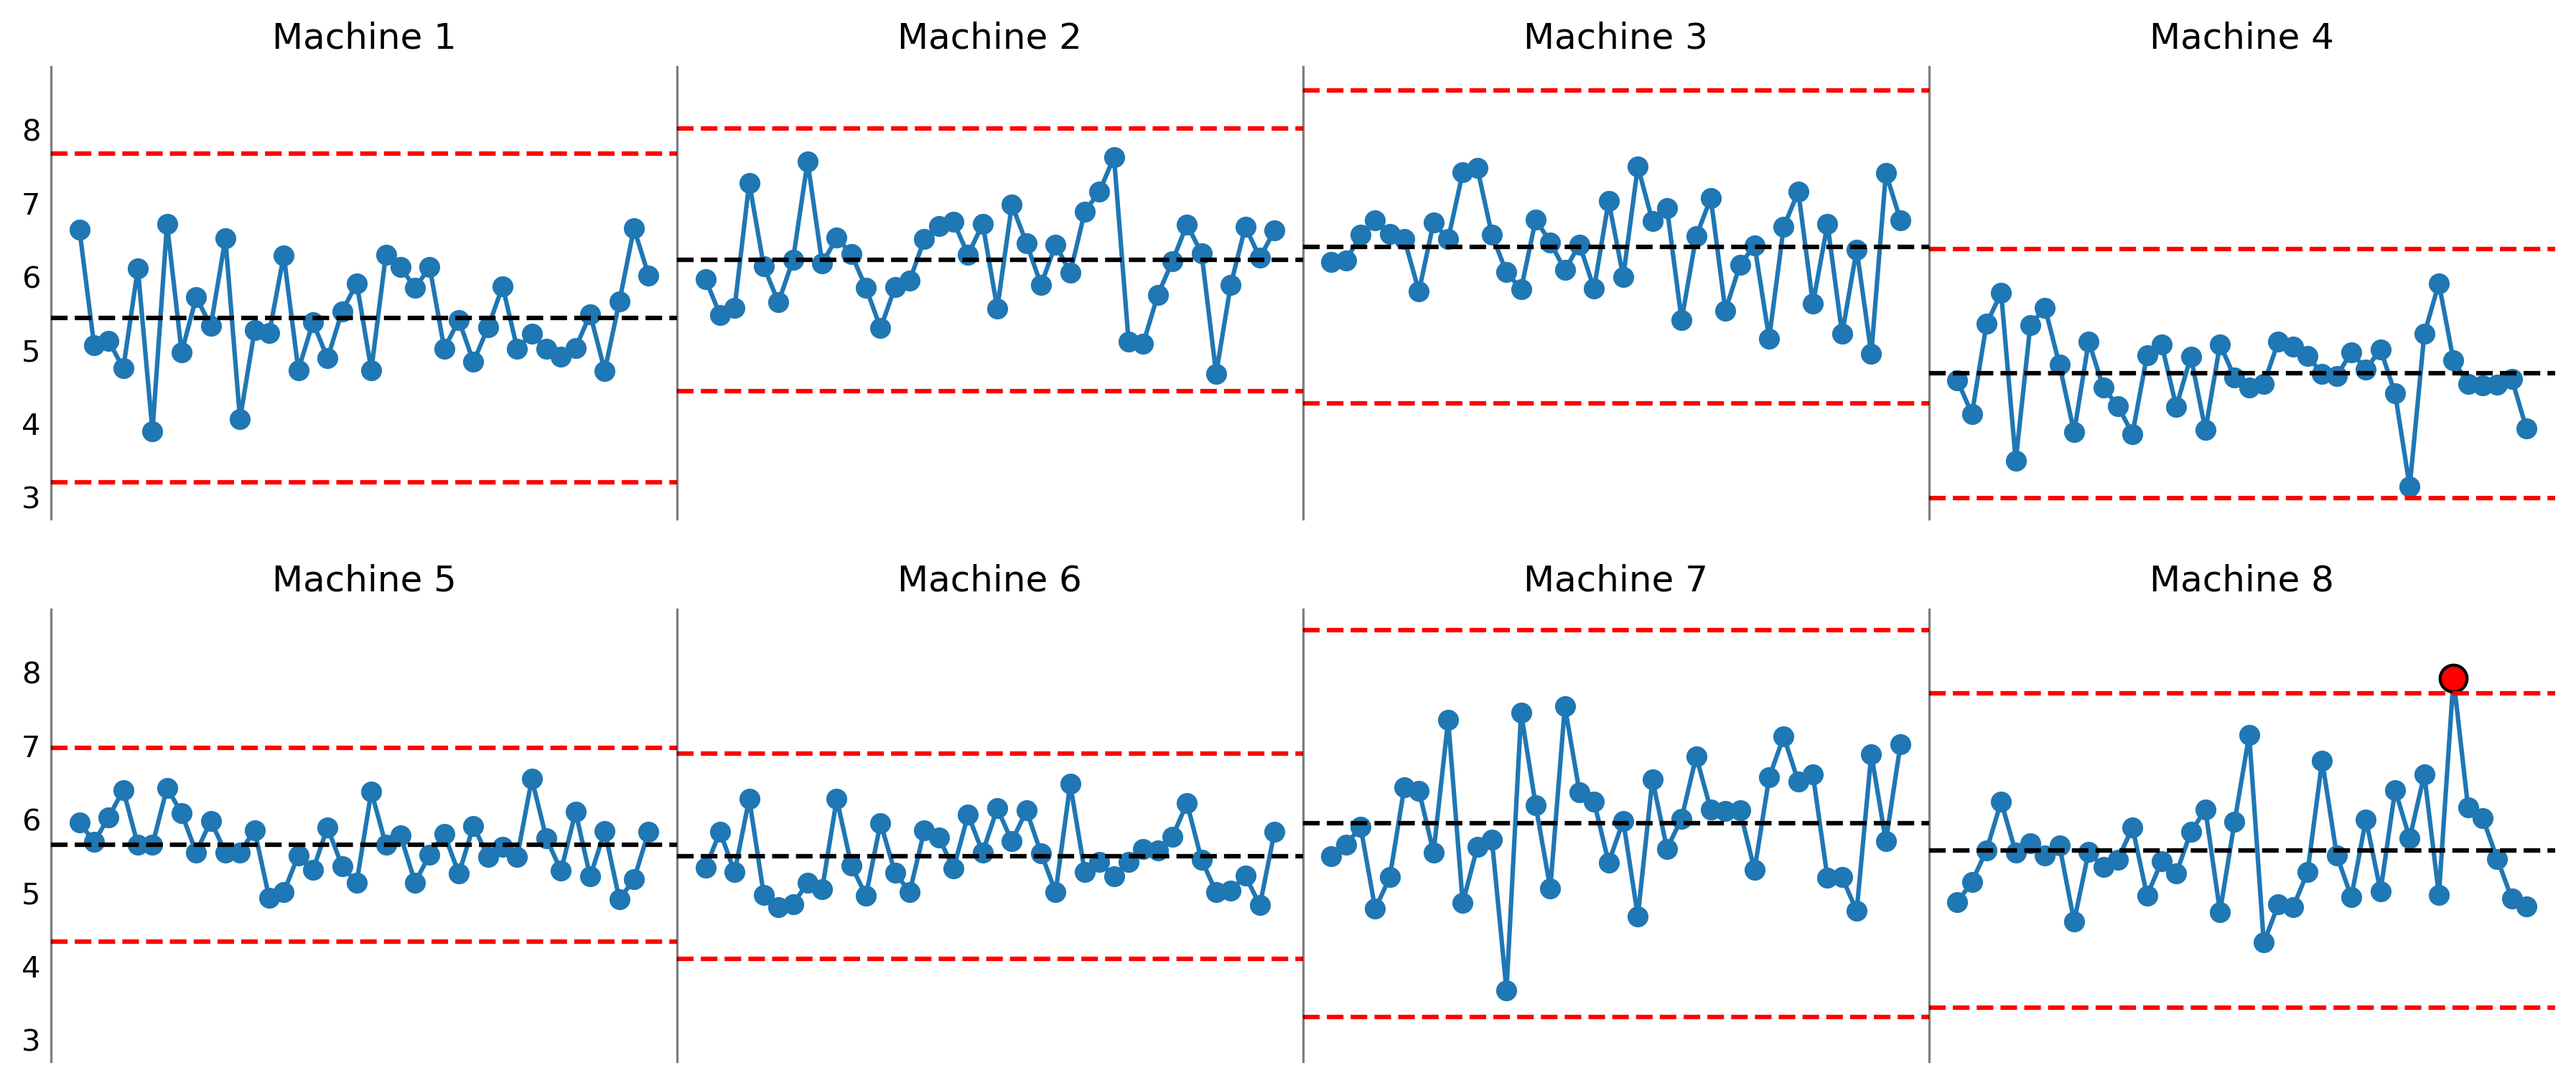

In [79]:
# Perform network analysis
na_results_df = na.network_analysis(list_of_dfs, 'Values', list_of_labels,
                   rows=2, cols=4, figsize=(15,6), title='')

In [80]:
# Show network analysis results DataFrame
na_results_df

,Labels,Mean,UPL,LPL,PLR,AmR,URL,Characterization
0,Machine 1,5.43700,7.678221,3.195779,4.482441,0.842564,2.753499,Predictable
1,Machine 2,6.23150,8.023931,4.439069,3.584862,0.673846,2.202129,Predictable
2,Machine 3,6.40825,8.536932,4.279568,4.257364,0.800256,2.615238,Predictable
3,Machine 4,4.68175,6.381422,2.982078,3.399344,0.638974,2.088168,Predictable
4,Machine 5,5.65575,6.972791,4.338709,2.634082,0.495128,1.618079,Predictable
5,Machine 6,5.49475,6.892273,4.097227,2.795046,0.525385,1.716957,Predictable
6,Machine 7,5.94575,8.579832,3.311668,5.268164,0.990256,3.236158,Predictable
7,Machine 8,5.57650,7.714049,3.438951,4.275097,0.803590,2.626131,Unpredictable


## Fig 7: Limit chart network analysis

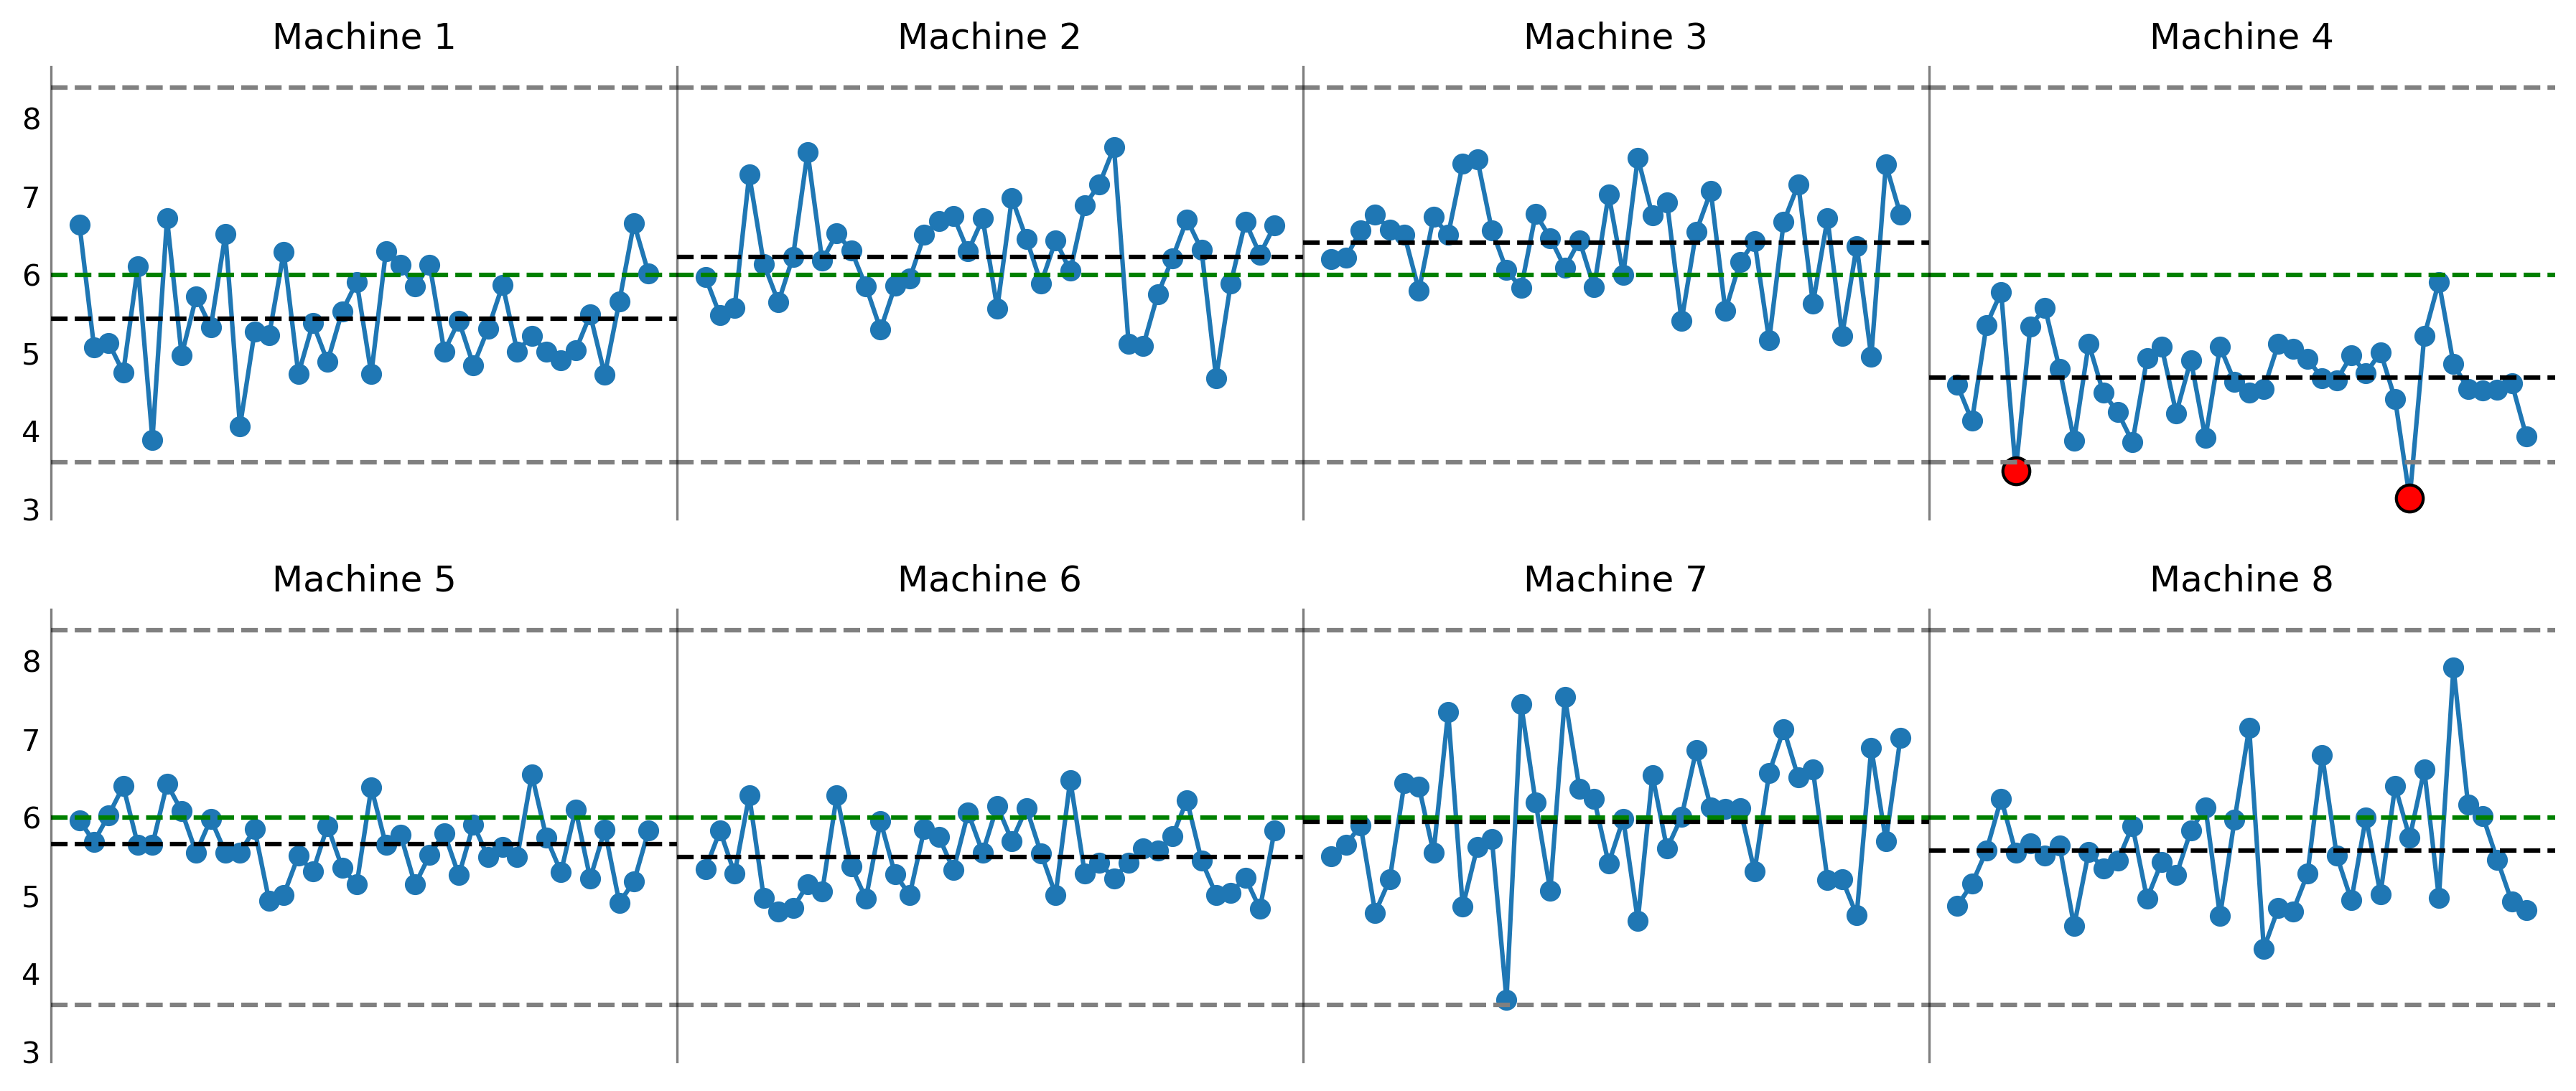

In [87]:
# Perform limit chart network analysis
limit_chart_results = na.limit_chart_network_analysis(list_of_dfs, 'Values', list_of_labels,
                                USL, LSL, target, rows=2, cols=4, 
                                figsize=(15,6), title='')

In [91]:
# Show limit chart network analysis results
limit_chart_results

,Labels,Mean,UPL,LPL,PLR,Target,USL,LSL,Tolerance,Centering Distance,Tolerance Delta
0,Machine 1,5.43700,7.678221,3.195779,4.482441,6,8.4,3.6,4.8,-0.56300,-0.317559
1,Machine 2,6.23150,8.023931,4.439069,3.584862,6,8.4,3.6,4.8,0.23150,-1.215138
2,Machine 3,6.40825,8.536932,4.279568,4.257364,6,8.4,3.6,4.8,0.40825,-0.542636
3,Machine 4,4.68175,6.381422,2.982078,3.399344,6,8.4,3.6,4.8,-1.31825,-1.400656
4,Machine 5,5.65575,6.972791,4.338709,2.634082,6,8.4,3.6,4.8,-0.34425,-2.165918
5,Machine 6,5.49475,6.892273,4.097227,2.795046,6,8.4,3.6,4.8,-0.50525,-2.004954
6,Machine 7,5.94575,8.579832,3.311668,5.268164,6,8.4,3.6,4.8,-0.05425,0.468164
7,Machine 8,5.57650,7.714049,3.438951,4.275097,6,8.4,3.6,4.8,-0.42350,-0.524903


## Fig 8: Centering distance bar chart

In [128]:
# Calculate centering distance to na_results_df
na_results_df['Centering Distance'] = na_results_df['Mean'] - target

centering_distance = na_results_df[['Labels', 'Centering Distance', 'Characterization']]
# Sort centering distances lowest to highest and by characterization
centers_sorted = centering_distance.sort_values(by=['Characterization', 'Centering Distance'],
                                               ascending=[True, True]).reset_index(drop=True)

# Make 'Labels' column string
centers_sorted[['Labels','Characterization']] = centers_sorted[['Labels','Characterization']].astype('string')
# Make 'Centering Distance' column dtype numeric
centers_sorted['Centering Distance'] = pd.to_numeric(centers_sorted['Centering Distance'], errors='coerce')

centers_sorted.dtypes

Labels                 string
Centering Distance    float64
Characterization       string
dtype: object

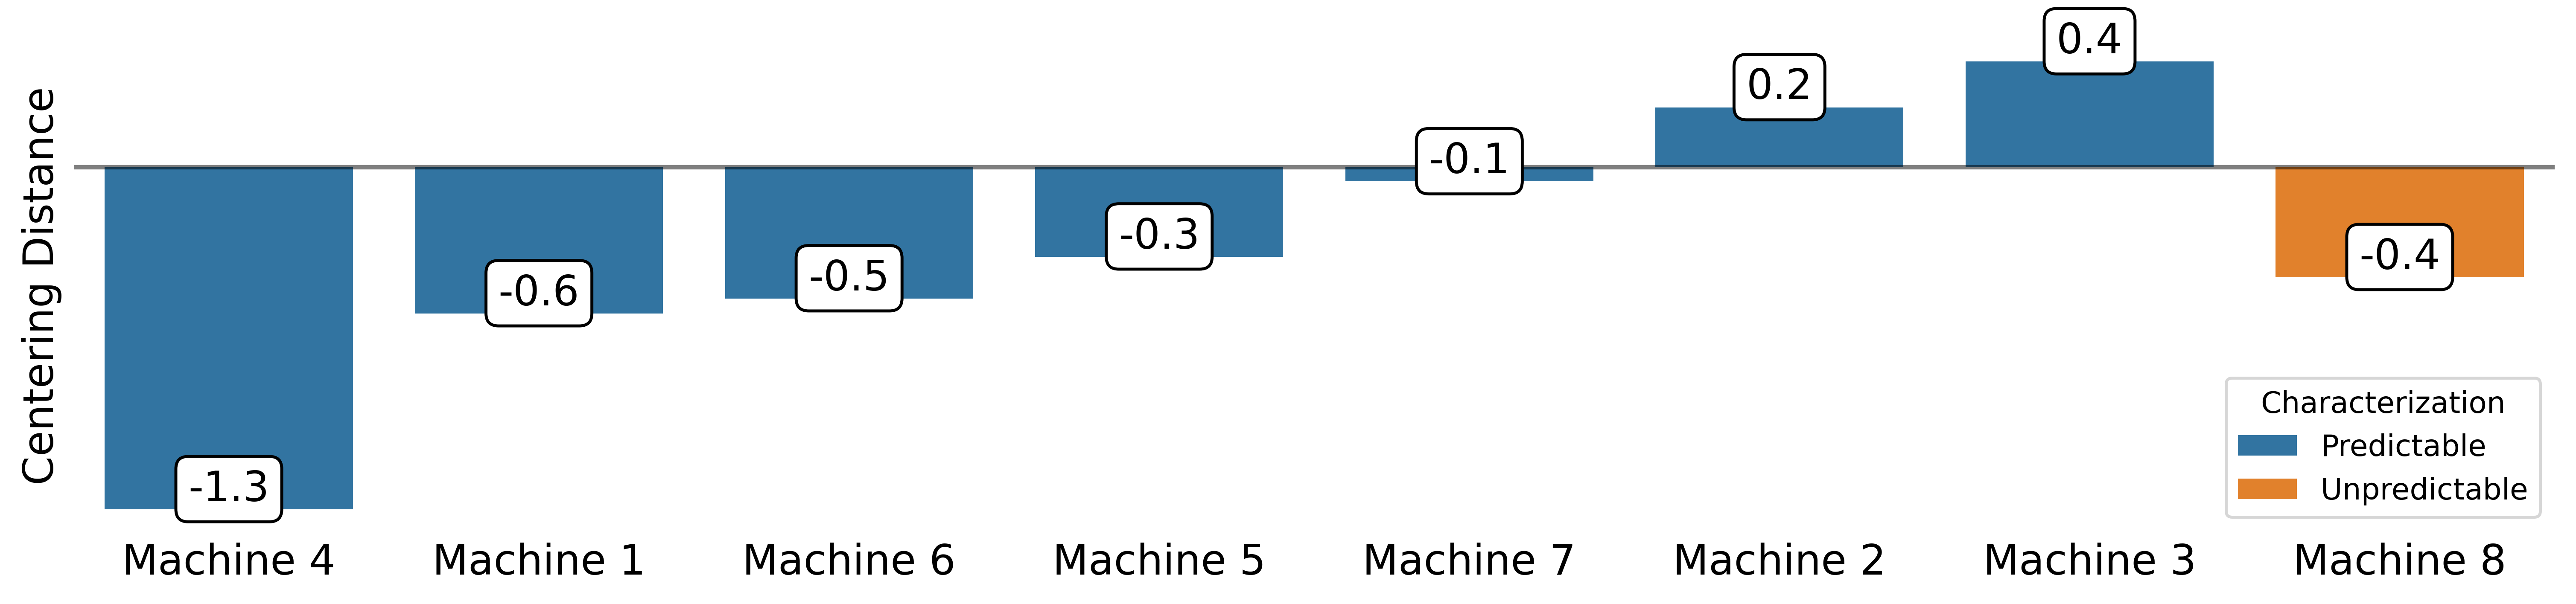

In [132]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15,3), dpi=500)

# Plot data in bar chart
barplot = sns.barplot(centers_sorted,
                      y='Centering Distance',
                      x='Labels', 
                      palette=['tab:blue','tab:orange'],
                     hue='Characterization',
                     dodge=False)

# Add labels to each bar
for bar in barplot.patches:
    height = bar.get_height()  # Get the height of the bar
    
    # Ensure height is a finite number before adding text
    if not np.isfinite(height) or height == 0:
        continue  # Skip bars with NaN, Inf, or zero height

    ax.text(
        x=bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        y=height,  # Y-coordinate (top of the bar)
        s=f'{height:.1f}',  # Text to display
        ha='center',  # Horizontal alignment
        va='bottom',  # Align text slightly above the bar
        fontsize=14,
        bbox=dict(facecolor='white', boxstyle='round')
    )

# Plot horizontal black line at zero
ax.axhline(0, c='black', alpha=0.5)

# Despine
sns.despine(left=True, bottom=True)
ax.set_ylabel('Centering Distance', fontsize=14)

# Settings
ax.set(
    xlabel='',
    yticks=[]
)

# Remove xtick marks but keep xtick labels
ax.tick_params(axis='x', length=0, labelsize=14)

plt.show()

## Fig 9: Tolerance deltas bar chart

In [133]:
# Calculate tolerance delta
na_results_df['Tolerance Delta'] = na_results_df['PLR']-tolerance
tolerance_deltas = na_results_df[['Labels', 'Tolerance Delta', 'Characterization']]
tolerance_deltas_sorted = tolerance_deltas.sort_values(by=['Characterization','Tolerance Delta'], 
                                                        ascending=[True, False])
tolerance_deltas_sorted.dtypes

Labels               object
Tolerance Delta     float64
Characterization     object
dtype: object

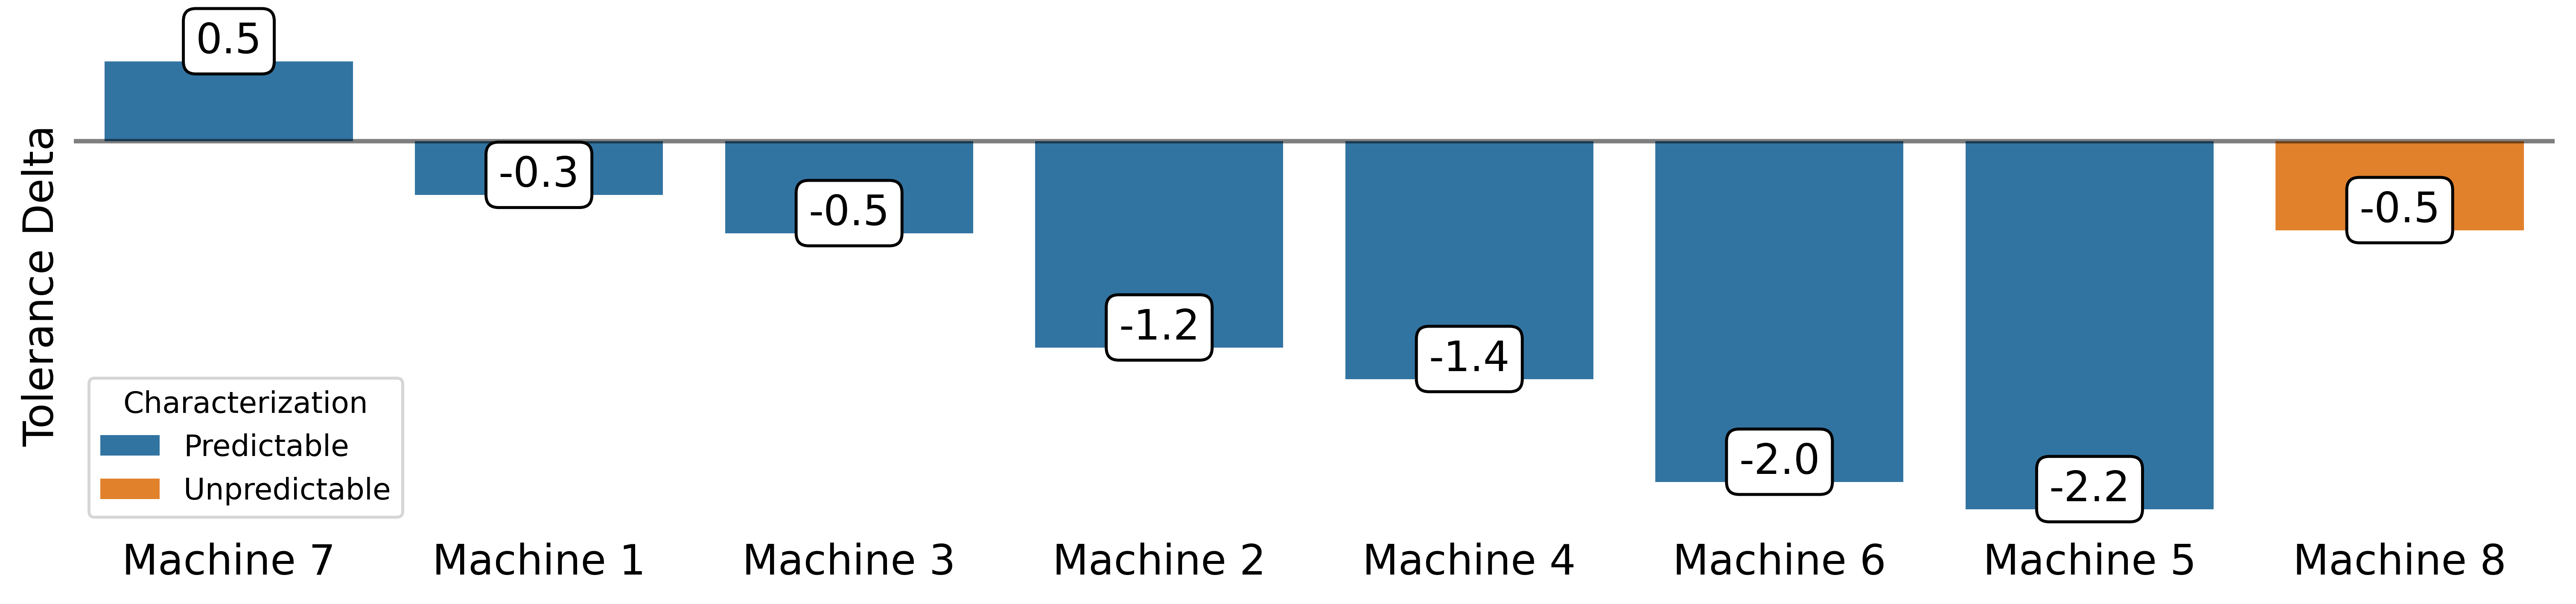

In [134]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15,3), dpi=500)

# Plot data in bar chart
barplot = sns.barplot(tolerance_deltas_sorted,
                      y='Tolerance Delta',
                      x='Labels', 
                      hue='Characterization',
                     dodge=False)

# Add labels to each bar
for bar in barplot.patches:
    height = bar.get_height()  # Get the height of the bar
    
    # Ensure height is a finite number before adding text
    if not np.isfinite(height) or height == 0:
        continue  # Skip bars with NaN, Inf, or zero height

    ax.text(
        x=bar.get_x() + bar.get_width() / 2,  # X-coordinate (center of the bar)
        y=height,  # Y-coordinate (top of the bar)
        s=f'{height:.1f}',  # Text to display
        ha='center',  # Horizontal alignment
        va='bottom',  # Align text slightly above the bar
        fontsize=14,
        bbox=dict(facecolor='white', boxstyle='round')
    )

# Plot horizontal black line at 0
ax.axhline(0, c='black', alpha=0.5)

# Despine figure
sns.despine(left=True, bottom=True)
ax.set_ylabel('Tolerance Delta', fontsize=14)

# Settings
ax.set(
    xlabel='',
    yticks=[]
)

# Remove xtick marks but keep xtick labels
ax.tick_params(axis='x', length=0, labelsize=14)

# Show plot
plt.show()